# Swiss Housing Price Predictor 🏠💰

Hello, we are Tobias, Sascha, and Florian. Our goal for this project is to build a predictive model for Swiss housing prices. We aim to achieve this by leveraging current web data. 

![Swiss House](https://archivaldesigns.com/cdn/shop/products/Peach-Tree-Front_1200x.jpg?v=1648224612)

This project will involve several steps:

1. **Data Collection**: Scrape housing data from various online sources.
2. **Preprocessing**: Clean and format the data for analysis.
3. **Exploratory Data Analysis**: Understand the data and find any interesting trends.
4. **Feature Engineering**: Create new features from the existing data to improve our model's performance.
5. **Model Building**: Train a machine learning model on our processed data.
6. **Evaluation**: Test our model's performance and make any necessary adjustments.

Our hope is that our model will be able to accurately predict housing prices, providing valuable insights for both buyers and sellers in the Swiss housing market. 

You can check out our code [here on GitHub](https://github.com/meichflo/ADS_Project_group3).

```python
# Sample Python Code
def hello_world():
    print("Hello, world!")

In [7]:
# Libraries
import os
import re
import json
import time
import random
import pandas as pd

from bs4 import BeautifulSoup

from prettytable import from_csv

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support import expected_conditions as EC

# Settings
import warnings
warnings.filterwarnings("ignore")

# Current working directory
print(f'Current working directory: {os.getcwd()}')

Current working directory: c:\Users\FMeic\data_science\ADS_Project_group3


In [10]:
# Set options for Chrome-Driver (headless mode)
opts = Options()
#opts.add_argument("--headless")
#opts.add_argument("user-agent=" + random.choice(ua_list))
service = Service(executable_path=r'C:\Tools\chromedriver\chromedriver.exe')
driver = webdriver.Chrome(service=service, options=opts)
# Chrome-Driver
driver = webdriver.Chrome(service=service, options=opts)

# Website to scrape
url = 'https://www.immoscout24.ch/de/immobilien/mieten/kanton-zuerich?pn=1'
driver.get(url)

# Get webpage number from url
pattern = r'=(.*)'
page = re.search(pattern, url)

# Get the full content of the website
source = driver.page_source

# Close driver
driver.close()

# Parse HTML content with BeautifulSoup
soup = BeautifulSoup(source, 'html.parser')

# Get links
links = []
link_elements = soup.find_all(class_='css-qqdlpa')
for element in link_elements:
    links.append('https://www.autoscout24.ch' + element['href'])

# Get types
types_elements = soup.find_all(class_='chakra-heading css-svmyrf')
types = [element.text for element in types_elements]

# Get prices
prices_elements = soup.find_all(class_='chakra-text css-bwl0or')
prices = [element.text for element in prices_elements]

# Dataframe
df = pd.DataFrame({ 'Page': page.group(1),
                    'Type': types,
                    'Price': prices,
                    'Weblink': links})

# Save to file
df.to_csv('autoscout24.csv', sep=";", index=False)

# Show file
with open('autoscout24.csv') as table_file:
    tab = from_csv(table_file, delimiter=';')
    
    # Set the alignment for all columns to 'l' (left-align)
    for field_name in tab.field_names:
        tab.align[field_name] = 'l'
    
    print(tab)

+------+------+-------+---------+
| Page | Type | Price | Weblink |
+------+------+-------+---------+
+------+------+-------+---------+


In [ ]:
#install geopy over your vsc terminal

#pip install geopy

In [42]:
from geopy.geocoders import Nominatim

# Initialize the geocoder
geolocator = Nominatim(user_agent="geoapiExercises")

# Input address
address = input("Please enter the address: ")

# Perform geolocation
location = geolocator.geocode(address)

# Extract latitude and longitude
latitude = location.latitude if location else None
longitude = location.longitude if location else None

print(f"Latitude: {latitude}, Longitude: {longitude}")


Latitude: 47.2691778, Longitude: 8.578620425462635


In [2]:
#install the following enviroment over your vsc terminal

#pip install openmeteo-requests
#pip install requests-cache retry-requests numpy pandas

In [1]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

Coordinates 47.27592086791992°N 8.529412269592285°E
Elevation 475.0 m asl
Timezone b'Europe/Berlin' b'CET'
Timezone difference to GMT+0 3600 s
                        date  temperature_2m_mean  sunshine_duration  \
0  2024-02-29 23:00:00+00:00             5.655583           0.083649   
1  2024-03-01 23:00:00+00:00             6.463916           8.431161   
2  2024-03-02 23:00:00+00:00             8.641000           5.843092   
3  2024-03-03 23:00:00+00:00             6.722250           3.344304   
4  2024-03-04 23:00:00+00:00             5.884751           0.760785   
5  2024-03-05 23:00:00+00:00             2.493083           0.000000   
6  2024-03-06 23:00:00+00:00             3.486833           4.176416   
7  2024-03-07 23:00:00+00:00             3.438917           9.377189   
8  2024-03-08 23:00:00+00:00             7.234751           8.376211   
9  2024-03-09 23:00:00+00:00             7.195167           4.000000   
10 2024-03-10 23:00:00+00:00             5.832667          10.680

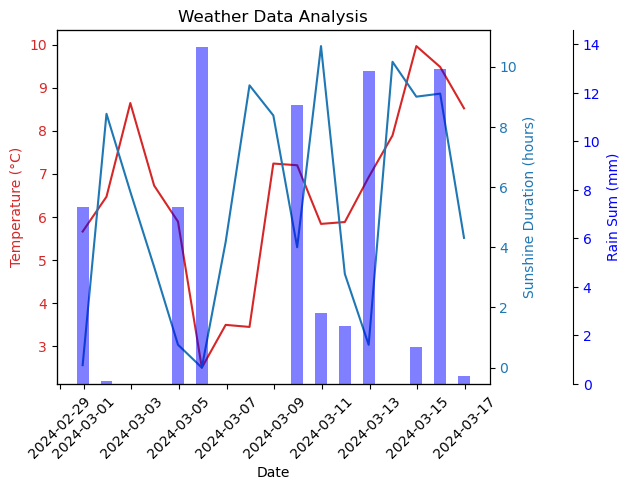

In [45]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": latitude,
	"longitude": longitude,
	"start_date": "2024-03-01",
	"end_date": "2024-03-17",
	"daily": ["temperature_2m_mean", "sunshine_duration", "rain_sum"],
	"timezone": "Europe/Berlin"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")



# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()
daily_sunshine_duration = daily.Variables(1).ValuesAsNumpy()
daily_rain_sum = daily.Variables(2).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["sunshine_duration"] = daily_sunshine_duration /3600
daily_data["rain_sum"] = daily_rain_sum

daily_dataframe = pd.DataFrame(data = daily_data)
print(daily_dataframe)

# Plotting
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
plt.xticks(rotation=45)
ax1.set_ylabel('Temperature (°C)', color=color)
ax1.plot(daily_dataframe['date'], daily_dataframe['temperature_2m_mean'], color=color, label='Temperature')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Sunshine Duration (hours)', color=color)
ax2.plot(daily_dataframe['date'], daily_dataframe['sunshine_duration'], color=color, label='Sunshine Duration')
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()  # instantiate a third axes for the rain sum
ax3.spines['right'].set_position(('outward', 60))  # Offset the right spine of ax3
color = 'tab:green'
ax3.set_ylabel('Rain Sum (mm)', color= "blue")
ax3.bar(daily_dataframe['date'], daily_dataframe['rain_sum'], color="blue", label='Rain Sum', alpha=0.5, width=0.5)
ax3.tick_params(axis='y', labelcolor="blue")

# Otherwise the right y-label is slightly clipped
fig.tight_layout()
plt.title('Weather Data Analysis')
plt.show()


In [ ]:
#Because my lovely group doesn't recognise my amazing work, I've finally implemented a clickable and interactive graph with Plotly.


